# Predicting COVID-19 with Random Forest

In [50]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime
from pandas.plotting import lag_plot
from matplotlib import pyplot as plt
from matplotlib.dates import date2num
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import json
plt.close("all")

euroData = pd.read_csv("data/euro_countries_padded.csv")
with open("data/iso_country_codes.json", "r") as read_file:
    countryCodes = json.load(read_file)

euroData.head(5)

,Unnamed: 0,iso_code,location,date,total_cases,new_cases,new_cases_smoothed,population,total_tests,new_tests,new_tests_smoothed
0,0,ALB,Albania,2019-12-31,0.0,0.0,0.0,2877800.0,0.0,0.0,0.0
1,1,ALB,Albania,2020-01-01,0.0,0.0,0.0,2877800.0,0.0,0.0,0.0
2,2,ALB,Albania,2020-01-02,0.0,0.0,0.0,2877800.0,0.0,0.0,0.0
3,3,ALB,Albania,2020-01-03,0.0,0.0,0.0,2877800.0,0.0,0.0,0.0
4,4,ALB,Albania,2020-01-04,0.0,0.0,0.0,2877800.0,0.0,0.0,0.0


In [88]:
df = euroData.groupby("date")["new_cases", "total_tests", "new_tests"].sum().reset_index()

df.date = pd.to_datetime(df.date)

df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['weekday'] = df['date'].dt.strftime('%A')

# Remove date column from features
features = df.drop('date', axis = 1)
features.head(5)

/home/alpakkan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,new_cases,total_tests,new_tests,day,month,year,weekday
0,0.0,0.0,0.0,31,12,2019,Tuesday
1,0.0,0.0,0.0,1,1,2020,Wednesday
2,0.0,0.0,0.0,2,1,2020,Thursday
3,0.0,0.0,0.0,3,1,2020,Friday
4,0.0,0.0,0.0,4,1,2020,Saturday


## Exploratory Data Analysis

The number of (rows, columns): (304, 7)


Text(0.5, 1.0, 'New Cases')

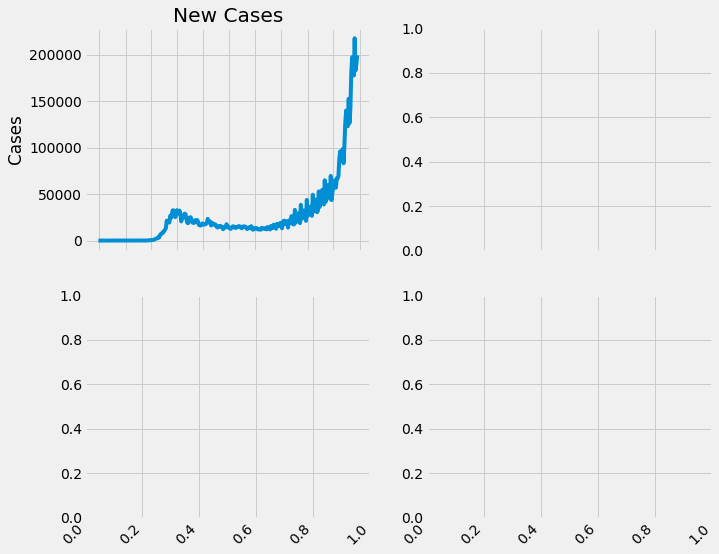

In [89]:
print('The number of (rows, columns):', features.shape)

# Get years, months, and days
years = features['year']
months = features['month']
days = features['day']

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Set pyplot style
plt.style.use('fivethirtyeight')

# Set up the plotting layout
f1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
f1.autofmt_xdate(rotation = 45)

# Plot new cases
ax1.plot(dates, features['new_cases'])
ax1.set_xlabel(''); ax1.set_ylabel('Cases'); ax1.set_title('New Cases')

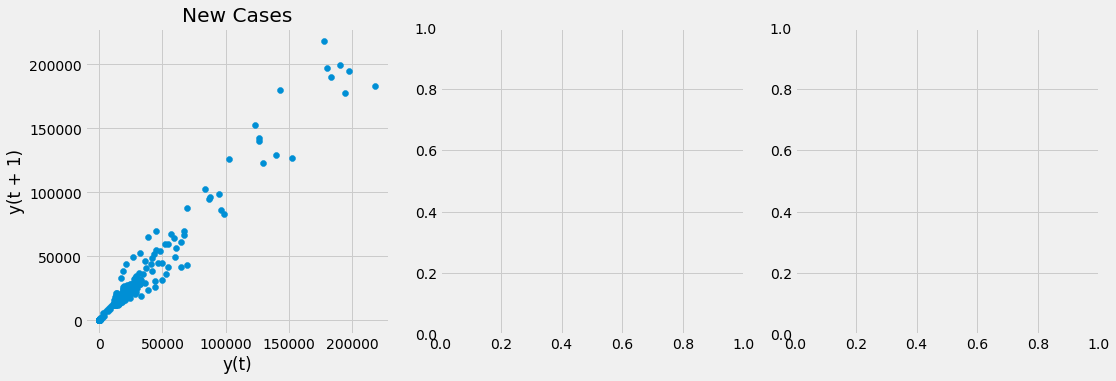

In [90]:
# Make lag plot
f2, (ax4, ax5, ax6) = plt.subplots(1, 3, figsize=(15, 5))
f2.tight_layout()
lag_plot(features['new_cases'], ax=ax4)
ax4.set_title('New Cases');

## Pre-processing: Make Time Series Stationary

### Try Transforming the Data

/home/alpakkan/.local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 1.0, 'Cbrt')

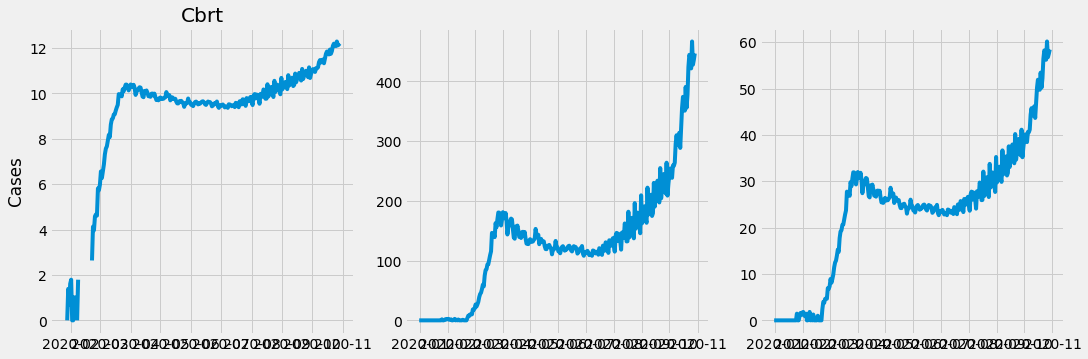

In [91]:
# Calculate the log
features['new_cases_log'] = np.log(features['new_cases'])

# Calculate the square root
features['new_cases_sqrt'] = np.sqrt(features['new_cases'])

# Calculate the cubed root
features['new_cases_cbrt'] = np.cbrt(features['new_cases'])

f3, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
f3.tight_layout()
ax1.plot(dates, features['new_cases_log'])
ax1.set_xlabel(''); ax1.set_ylabel('Cases'); ax1.set_title('Log')
ax2.plot(dates, features['new_cases_sqrt'])
ax2.set_xlabel(''); ax1.set_ylabel('Cases'); ax1.set_title('Sqrt')
ax3.plot(dates, features['new_cases_cbrt'])
ax3.set_xlabel(''); ax1.set_ylabel('Cases'); ax1.set_title('Cbrt')

### Try Rolling Means

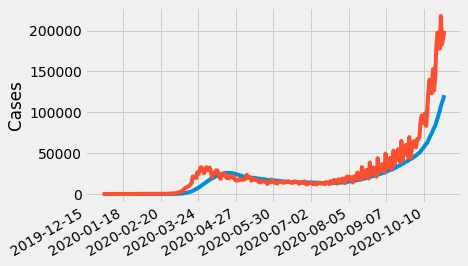

In [92]:
f4, ax = plt.subplots()
ax.plot(dates, features['new_cases'].rolling(window = 30).mean())
ax.plot(dates, features['new_cases'])
ax.set_xlabel(''); ax.set_ylabel('Cases'); ax1.set_title('Rolling Mean')

# rotate and align the tick labels so they look better
f4.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, (end-start)/10))

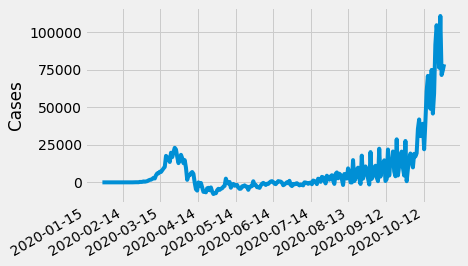

In [93]:
features['new_cases_rolling'] = features['new_cases'] - features['new_cases'].rolling(window = 30).mean()

f5, ax = plt.subplots()
ax.plot(dates, features['new_cases_rolling'])
ax.set_xlabel(''); ax.set_ylabel('Cases'); ax1.set_title('New Cases with the Rolling Mean Subtracted')

# rotate and align the tick labels so they look better
f5.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, (end-start)/10))

### Try Differencing

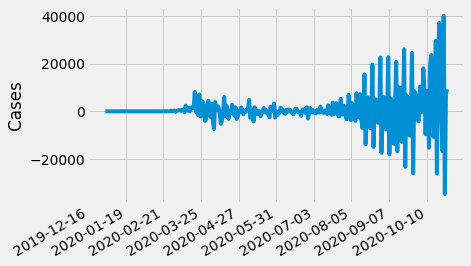

In [94]:
features['new_cases_diff'] = features['new_cases'].diff(periods=1)

f6, ax = plt.subplots()
ax.plot(dates, features['new_cases_diff'])
ax.set_xlabel(''); ax.set_ylabel('Cases'); ax1.set_title('Differenced New Cases')

# rotate and align the tick labels so they look better
f6.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, (end-start)/10))

## Feature Engineering

In [95]:
# Remove non-stationary series and stationarity attempts that did not work
features = features.drop(['new_cases', 'new_cases_log', 'new_cases_sqrt', 'new_cases_cbrt', 'new_cases_rolling'], axis = 1)

# Create lags
lag = 7

def build_lagged_features(s,lag=3,dropna=True):
    '''
    Builds a new DataFrame to facilitate regressing over all possible lagged features
    '''
    if type(s) is pd.DataFrame:
        new_dict={}
        for col_name in s:
            new_dict[col_name]=s[col_name]
            # create lagged Series
            for l in range(1,lag+1):
                new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
        res=pd.DataFrame(new_dict,index=s.index)

    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
    else:
        print('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res 

lagged_features = build_lagged_features(features.drop(['day', 'month', 'year', 'weekday'], axis = 1), lag=lag)
lagged_features['day'] = features['day'][lag:]
lagged_features['month'] = features['month'][lag:]
lagged_features['year'] = features['year'][lag:]
lagged_features['weekday'] = features['weekday'][lag:]

features = lagged_features

# One-hot encode weekdays
features = pd.get_dummies(features)

features.head(10)

,total_tests,total_tests_lag1,total_tests_lag2,total_tests_lag3,total_tests_lag4,total_tests_lag5,total_tests_lag6,total_tests_lag7,new_tests,new_tests_lag1,...,day,month,year,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8,1,2020,0,0,0,0,0,0,1
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9,1,2020,0,0,0,0,1,0,0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10,1,2020,1,0,0,0,0,0,0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11,1,2020,0,0,1,0,0,0,0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12,1,2020,0,0,0,1,0,0,0
13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,13,1,2020,0,1,0,0,0,0,0
14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,14,1,2020,0,0,0,0,0,1,0
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15,1,2020,0,0,0,0,0,0,1
16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16,1,2020,0,0,0,0,1,0,0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17,1,2020,1,0,0,0,0,0,0


## Training

In [97]:
# Splitting into labels and features
labels = np.array(features['new_cases_diff'])
features = features.drop('new_cases_diff', axis = 1)
feature_list = list(features.columns)
features = np.array(features)

# Splitting into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 49)

In [98]:
# TODO: Create baseline predictions

In [99]:
# Train random forest model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 49)
rf.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=49, verbose=0, warm_start=False)

In [100]:
# Predict on test data
predictions = rf.predict(test_features)

## Evaluation

In [101]:
# Get Mean Absolute Error (MAE)
errors = abs(predictions - test_labels)
print('MAE:', round(np.mean(errors), 2), 'new cases')

MAE: 3663.9 new cases


In [102]:
# Get feature importances
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort feature importances descendingly by importance
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: new_cases_diff_lag7  Importance: 0.53
Variable: new_cases_diff_lag6  Importance: 0.09
Variable: new_cases_diff_lag1  Importance: 0.08
Variable: new_cases_diff_lag5  Importance: 0.05
Variable: total_tests_lag4     Importance: 0.03
Variable: new_tests_lag4       Importance: 0.03
Variable: new_cases_diff_lag3  Importance: 0.03
Variable: new_tests_lag6       Importance: 0.02
Variable: new_cases_diff_lag4  Importance: 0.02
Variable: total_tests          Importance: 0.01
Variable: total_tests_lag1     Importance: 0.01
Variable: total_tests_lag2     Importance: 0.01
Variable: total_tests_lag5     Importance: 0.01
Variable: total_tests_lag6     Importance: 0.01
Variable: total_tests_lag7     Importance: 0.01
Variable: new_tests            Importance: 0.01
Variable: new_tests_lag1       Importance: 0.01
Variable: new_tests_lag2       Importance: 0.01
Variable: new_tests_lag3       Importance: 0.01
Variable: new_tests_lag5       Importance: 0.01
Variable: new_tests_lag7       Importanc